# NOISE ESTIMATION AND FILTERING

After sky subtraction, the error was computed by simplifying the error propagation process. Instead of propagating the Poissonian error at each step of the calibration, the image was flattened at the final stage of the calibration process. To estimate the error, the sky noise, which is expected to follow a Gaussian distribution centered around zero, was analyzed.

A Gaussian was fitted to the pixel values, but only the negative side of the distribution was used, as the positive side is contaminated by real sources. This exclusion of the positive side ensures that the error estimation is not biased by real objects in the image.

The width (sigma) of the fitted Gaussian, derived from the negative counts, represents the sky noise and serves as the error estimate for the image. This approach is valid because, after sky subtraction, the noise in the image is primarily due to the sky background, and the Gaussian fit provides a robust estimate of this noise. By excluding the positive side, the error estimate remains unaffected by real sources or structures, ensuring a cleaner and more accurate result.

This procedure is correct because the noise in the sky background is often Gaussian in nature, and focusing on the sky noise after calibration avoids the complications introduced by real sources. The method also simplifies error propagation by performing it in a final step, making it computationally efficient while still yielding a reliable estimate of the error.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [17]:
from astropy.io import fits

filter = ['Ha', 'Hb','g','r','i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}
filter_cmap = {'Ha': 'hot','Hb': 'magma','g': 'bone','r':'hot','i':'copper'}
image = {}
noise = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        image[f] = hdul[0].data
          

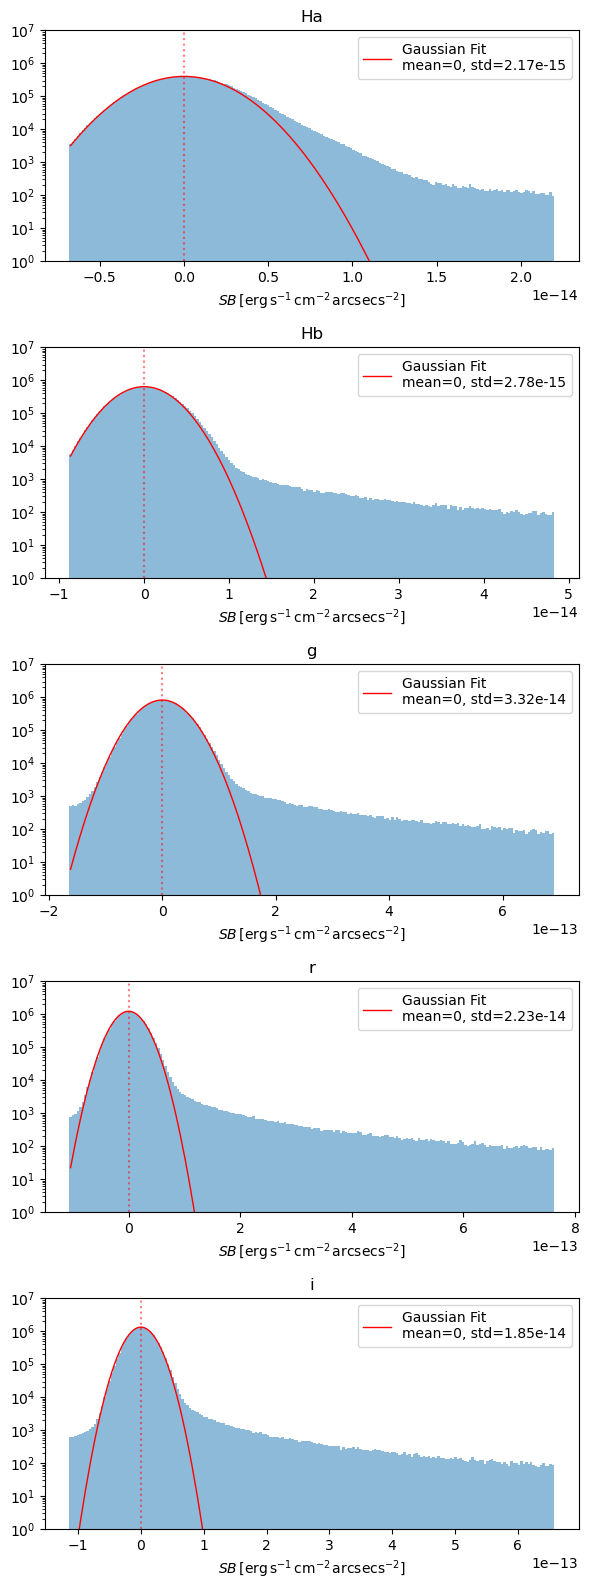

In [5]:
from scipy.stats import norm

fig, ax = plt.subplots(5,1,figsize=(6, 16))
#fig.suptitle("Error Estimation")

noise = {}

for i, f in enumerate(filter):

    flattened_image = image[f].flatten() 

    lower_threshold = np.quantile(flattened_image, 0.001)
    upper_threshold = np.quantile(flattened_image, 0.999)
    flattened_image = flattened_image[(flattened_image >= lower_threshold) & (flattened_image <= upper_threshold)]
    
    bin_edges = np.linspace(min(flattened_image),max(flattened_image), 200)

    hist, bins, _  = ax[i].hist(flattened_image, bins=bin_edges, alpha=0.5)  
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Fit a Gaussian to the NEGATIVE data only
    flattened_image_negative = flattened_image[flattened_image<0]
    mean, std = norm.fit(np.concatenate((flattened_image_negative,-flattened_image_negative)))
    noise[f] = std

    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i].plot(bin_centers, gaussian_curve, label=f"Gaussian Fit\nmean=0, std={std:.2e}", color='red', lw=1)
    ax[i].axvline(x=0,linestyle=':',c='r',alpha=0.5)
    
    ax[i].set_ylim(1,1e7)
    ax[i].set_yscale("log")
    
    ax[i].set_title(f)
    ax[i].set_xlabel("$SB \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")
    ax[i].legend()

plt.tight_layout()
plt.show()

# IMAGE PROCESSING

Smoothing (Low-Pass Filters).

To achieve a reasonable SNR of at least 5 for E(B−V), rebinning must be performed by combining multiple pixels into a single pixel. This can be done with Low-Pass Filters

A low-pass filter is a type of signal processing filter that allows low-frequency components to pass through while attenuating or suppressing high-frequency components. In the context of image processing, low-pass filters are used for smoothing or blurring images by removing noise or fine details.

$$I'(x,y)=\sum_{u=-k}^k\sum_{v=-k}^k I(x+u,y+v)\cdot h(u,v)$$

- $I(x,y)$: Original image intensity at $(x,y)$
- $I′(x,y)$: Filtered image intensity at $(x,y)$
- $h(u,v)$: Filter kernel (defines the filter behavior)
- $k$: Defines the size of the kernel (e.g., 3×3, 5×5).

Filter kernels:

1. Gaussian Filter: Blurs an image using a Gaussian kernel. Smooths edges but introduces slight blurring.
2. Median Filter: Replaces each pixel with the median value of its neighborhood. Good for removing salt-and-pepper noise.
3. Box Filter (Average Filter): Replaces each pixel with the average of its neighborhood.

If the HβHβ​ flux is very low in certain regions, causing the Balmer decrement to appear anomalously high, the question arises whether the measurement is reliable enough to conclude that the decrement is "genuine." You need to check whether the Hβ​ flux is significantly different from zero. A flux near zero might indicate a poor signal-to-noise ratio (SNR), so you should calculate the SNR for both Hα and Hβ​. A very low SNR in Hβ​ could lead to significant uncertainties in the decrement. For instance, if the SNR of Hβ​ is low, then its measurement might be dominated by noise rather than a true physical feature.

In [18]:
from scipy.ndimage import gaussian_filter

sigma = 10

gaussian_filter = {
    'Ha': gaussian_filter(image['Ha'], sigma=sigma),
    'Hb': gaussian_filter(image['Hb'], sigma=sigma)
    }


In [19]:
from scipy.ndimage import median_filter

size = 10

median_filter = {
    'Ha' : median_filter(image['Ha'], size=10),
    'Hb' : median_filter(image['Hb'], size=10)
    }


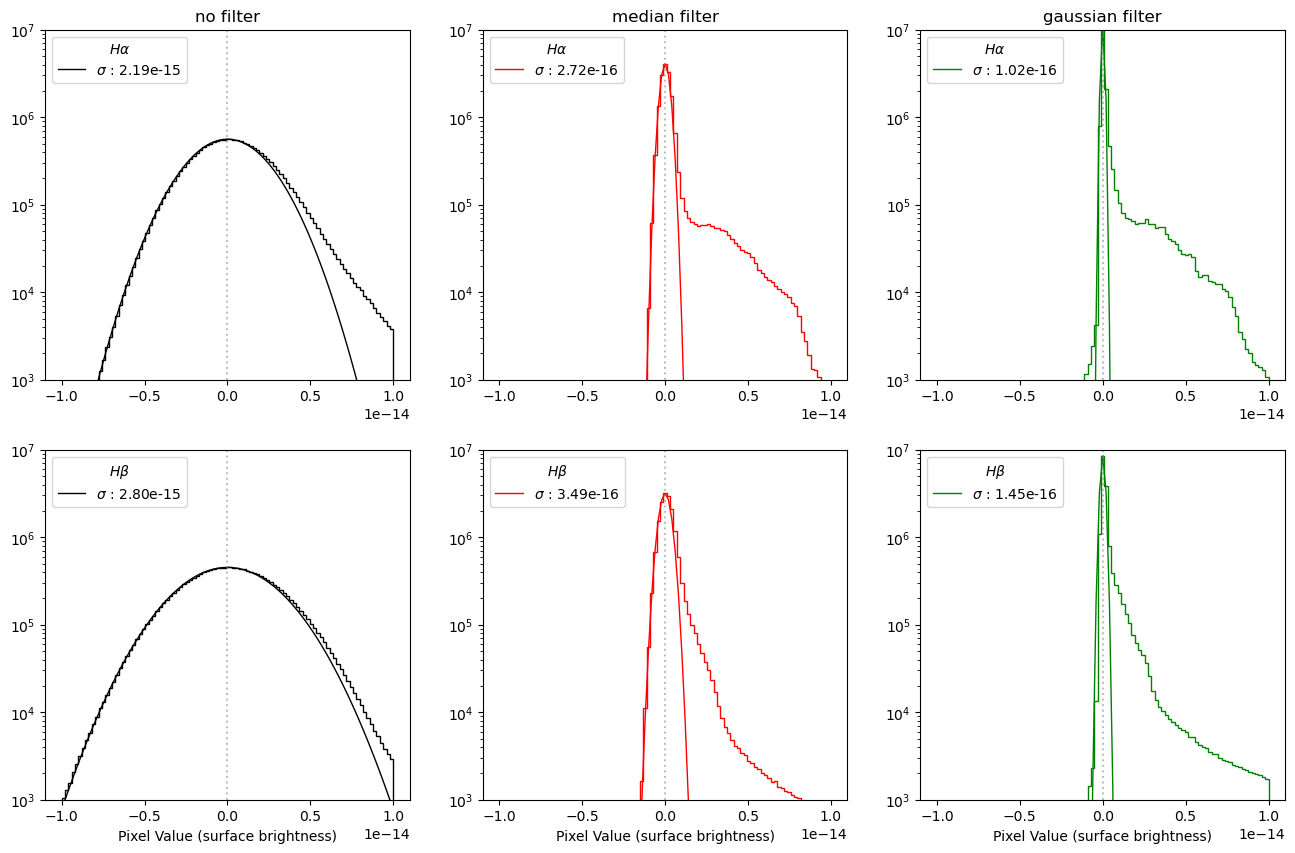

In [38]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
#ax = ax.flatten()
#ax[0].set_title('$H\\alpha$')
#ax[1].set_title('$H\\beta$')


bins = np.linspace(-1e-14, 1e-14, 100)

for i,f in enumerate(['Ha','Hb']):

    ### No filter ###
    
    image_flat = image[f].flatten()
    image_flat = image_flat[(image_flat >= -1e-14) & (image_flat <= 1e-14)]
    
    hist, bins, _ = ax[i,0].hist(image_flat, bins=bins, histtype='step', color='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
        
    image_flat_negative = image_flat[image_flat<0]
    mean, std = norm.fit(np.concatenate((image_flat_negative,-image_flat_negative)))
    
    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i,0].plot(bin_centers, gaussian_curve, label=f"$\sigma$ : {std:.2e}", color='black', lw=1)
    ax[i,0].axvline(x=0,linestyle=':',c='grey',alpha=0.5)


    ### Median Filter ###
    
    image_flat = median_filter[f].flatten()
    image_flat = image_flat[(image_flat >= -1e-14) & (image_flat <= 1e-14)]
    
    hist, bins, _ = ax[i,1].hist(image_flat, bins=bins, histtype='step', color='red')
    bin_centers = (bins[:-1] + bins[1:]) / 2
        
    image_flat_negative = image_flat[image_flat<0]
    mean, std = norm.fit(np.concatenate((image_flat_negative,-image_flat_negative)))
    
    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i,1].plot(bin_centers, gaussian_curve, label=f"$\sigma$ : {std:.2e}", color='red', lw=1)
    ax[i,1].axvline(x=0,linestyle=':',c='grey',alpha=0.5)

    
    ### Gaussian Filter ###
    
    image_flat = gaussian_filter[f].flatten()
    image_flat = image_flat[(image_flat >= -1e-14) & (image_flat <= 1e-14)]
    
    hist, bins, _ = ax[i,2].hist(image_flat, bins=bins, histtype='step', color='green')
    bin_centers = (bins[:-1] + bins[1:]) / 2
        
    image_flat_negative = image_flat[image_flat<0]
    mean, std = norm.fit(np.concatenate((image_flat_negative,-image_flat_negative)))
    
    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i,2].plot(bin_centers, gaussian_curve, label=f"$\sigma$ : {std:.2e}", color='green', lw=1)
    ax[i,2].axvline(x=0,linestyle=':',c='grey',alpha=0.5)

    for k in range(3):
        ax[i,k].set_yscale('log')
        ax[i,k].set_ylim(1e3,1e7)

        
for k in range(3): 
    ax[0,k].legend(loc='upper left',title='$H\\alpha$')
    ax[1,k].legend(loc='upper left',title='$H\\beta$')
    ax[1,k].set_xlabel('Pixel Value (surface brightness)')

ax[0,0].set_title('no filter')
ax[0,1].set_title('median filter')
ax[0,2].set_title('gaussian filter')

plt.show()


In [20]:
import os

output_folder = "data/cleaned_calibrated"

for f in ['Ha','Hb']:

    fit_filename = os.path.join(output_folder, f"{f}_median_filter.fit")
    primary_hdu = fits.PrimaryHDU(data=median_filter[f])


for f in ['Ha','Hb']:

    fit_filename = os.path.join(output_folder, f"{f}_gaussian_filter.fit")
    primary_hdu = fits.PrimaryHDU(data=gaussian_filter[f])

    primary_hdu.writeto(fit_filename, overwrite=True)

# Mask stars

In [21]:
### === Code to mask stars === ###

from astropy.io import fits
with fits.open('data/cleaned_calibrated/Ha_calibrated.fit') as hdul:
    header = hdul[0].header
    params_ra = [header.get(f'RA_A{i}') for i in range(3)]
    params_dec = [header.get(f'DEC_B{i}') for i in range(3)]

def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})

stars_astrometry_nebula = []
center_x, center_y = radec_to_xy(328.370134,47.266320) 
for star in stars_astrometry:
    if (star['x']-center_x)**2 + (star['y']-center_y)**2 <= 700**2:
        stars_astrometry_nebula.append(star)

# central star is excluded because it creates issues



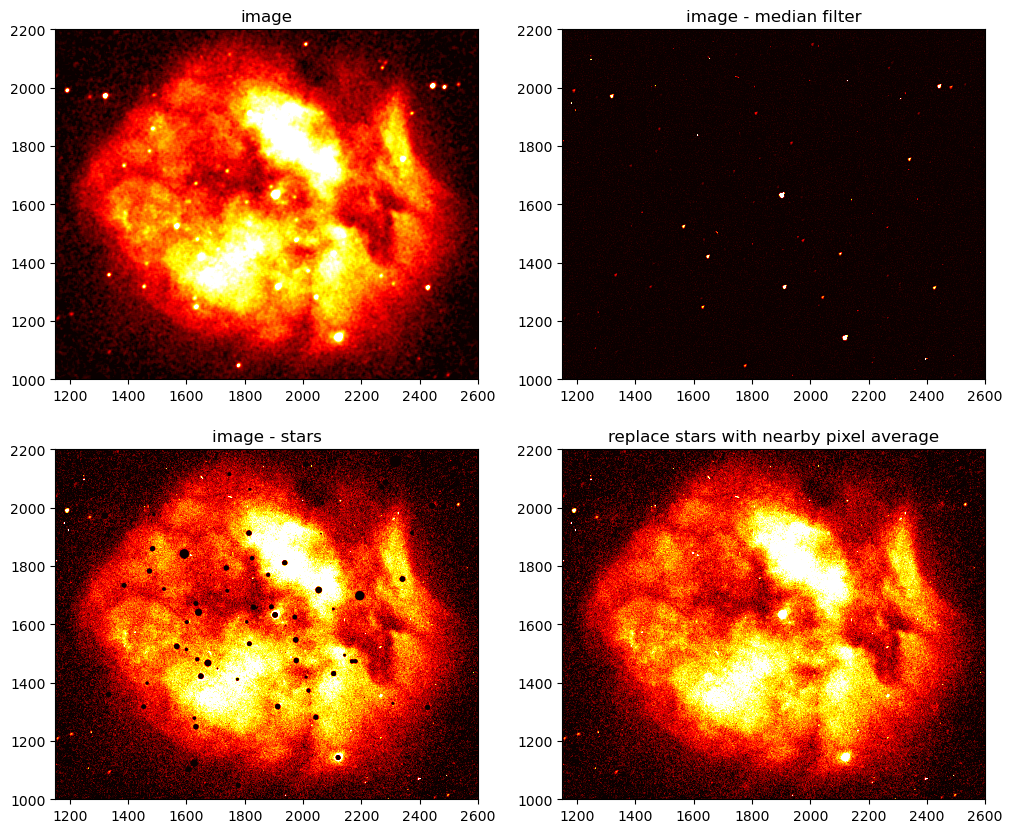

In [9]:
### === Code to mask stars === ###

from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_com
from astropy.modeling import models, fitting

cleaned_image = {
    'Ha': image['Ha'] - median_filter['Ha'],
    'Hb': image['Ha'] - median_filter['Hb']
}

fig,axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()

axes[0].imshow(median_filter['Ha'], cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[0].set_title("image")

axes[1].imshow(cleaned_image['Ha'], cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.999)],origin='lower')
axes[1].set_title("image - median filter")

masked_Ha_ = np.copy(image['Ha'])  
masked_Hb_ = np.copy(image['Hb'])

masked_Ha = np.copy(image['Ha'])  
masked_Hb = np.copy(image['Hb']) 

for star in stars_astrometry_nebula:
    
    if True:

        l = 30
        rectangle = cleaned_image['Ha'][int(star['y'] - l):int(star['y'] + l), 
                                        int(star['x'] - l):int(star['x'] + l)]
        y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
        g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
        fit = fitting.LevMarLSQFitter()
        g_fit = fit(g_init, x, y, rectangle)
            
        refined_x = star['x'] - l + g_fit.x_mean.value
        refined_y = star['y'] - l + g_fit.y_mean.value

        sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
        fwhm_x = 2.355 * sigma_x
        fwhm_y = 2.355 * sigma_y
        fwhm = (fwhm_x + fwhm_y) / 2
        y, x = np.ogrid[:masked_Ha.shape[0], :masked_Hb.shape[1]] # circular aperture mask around the star

        # For a symmetric Gaussian, the flux has reduced by approximately 98.89% at 1.5×FWHM
        if fwhm < l/2:
            mask_radius = 1.5 * fwhm 
            mask = (x - refined_x)**2 + (y - refined_y)**2 <= mask_radius**2    
            masked_Ha_[mask] = 0
            masked_Hb_[mask] = 0


            mask_radius_for_averaging = 2 * fwhm
            mask_for_averaging = ((x - refined_x)**2 + (y - refined_y)**2 <= mask_radius_for_averaging**2) & \
                                 ((x - refined_x)**2 + (y - refined_y)**2 > mask_radius**2)


            surrounding_pixels_Ha = image['Ha'][mask_for_averaging]  
            surrounding_pixels_Hb = image['Hb'][mask_for_averaging]

            # Compute the average of the surrounding pixels
            average_Ha = surrounding_pixels_Ha.mean()
            average_Hb = surrounding_pixels_Hb.mean()
            std_Ha = surrounding_pixels_Ha.std()
            std_Hb = surrounding_pixels_Hb.std()

            masked_Ha[mask] = np.random.normal(loc=average_Ha, scale=std_Ha, size=masked_Ha[mask].shape)
            masked_Hb[mask] = np.random.normal(loc=average_Hb, scale=std_Hb, size=masked_Hb[mask].shape)


axes[2].imshow(masked_Ha_, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[2].set_title("image - stars")

axes[3].imshow(masked_Ha, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[3].set_title("replace stars with nearby pixel average")

for i in range(4):
    axes[i].set_xlim(1150,2600)
    axes[i].set_ylim(1000,2200)
plt.show()

del masked_Ha_, masked_Hb_


In [22]:
### save gaussian smoothed images in fits for science ###

from scipy.ndimage import gaussian_filter
sigma = 10

masked_Ha = np.where(np.isnan(masked_Ha), 0, masked_Ha)
masked_Hb = np.where(np.isnan(masked_Hb), 0, masked_Hb)

masked_Ha_gauss = gaussian_filter(masked_Ha, sigma=sigma)
masked_Hb_gauss = gaussian_filter(masked_Hb, sigma=sigma)

### Ha ###
fit_filename = os.path.join(output_folder, f"Ha_gaussian_filter_masked_stars.fit")
primary_hdu = fits.PrimaryHDU(data=masked_Ha_gauss)
primary_hdu.writeto(fit_filename, overwrite=True)

### Hb ###
fit_filename = os.path.join(output_folder, f"Hb_gaussian_filter_masked_stars.fit")
primary_hdu = fits.PrimaryHDU(data=masked_Hb_gauss)
primary_hdu.writeto(fit_filename, overwrite=True)

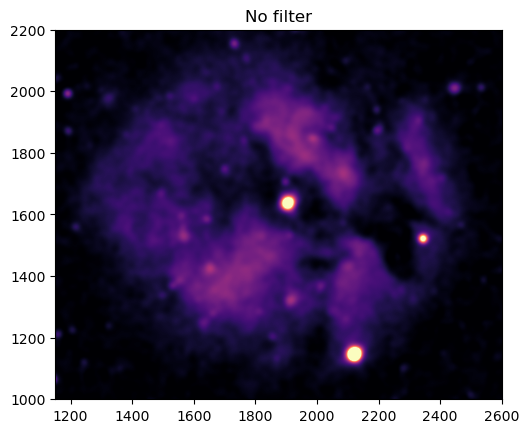

In [24]:
plt.title("No filter")
plt.imshow(masked_Hb_gauss, cmap='magma',clim=[0,np.quantile(image['Ha'], 0.99)],origin='lower')
plt.xlim(1150,2600)
plt.ylim(1000,2200)
plt.show()

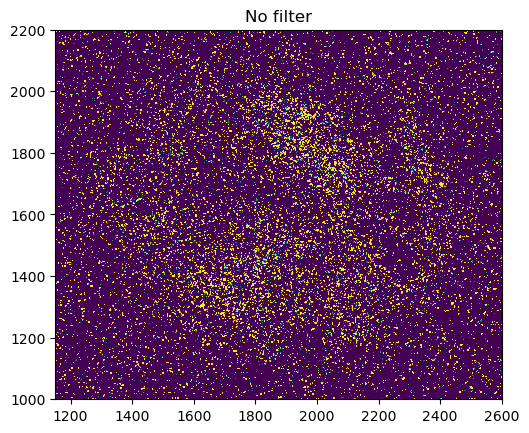

In [33]:
plt.title("No filter")
plt.imshow(image['Ha']/image['Hb'], cmap='viridis',clim=[3,5],origin='lower')
plt.xlim(1150,2600)
plt.ylim(1000,2200)
plt.show()

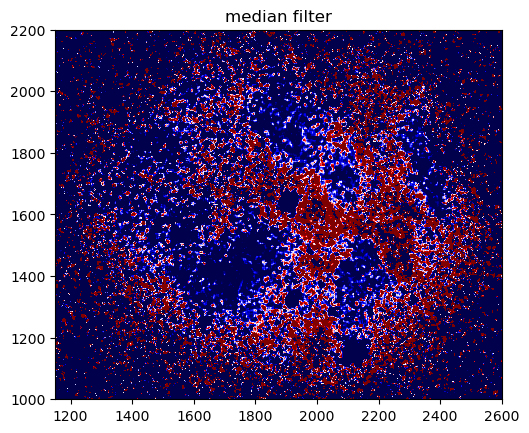

In [39]:
plt.title("median filter")
plt.imshow(median_filter['Ha']/median_filter['Hb'], cmap='seismic',clim=[3,5],origin='lower')
plt.xlim(1150,2600)
plt.ylim(1000,2200)
plt.show()

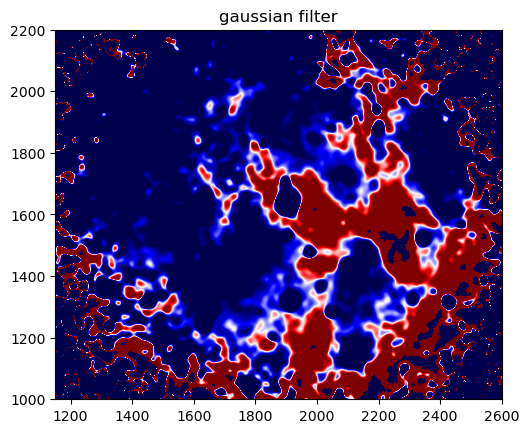

In [40]:
plt.title("gaussian filter")
plt.imshow(gaussian_filter['Ha']/gaussian_filter['Hb'], cmap='seismic',clim=[3,5],origin='lower')
plt.xlim(1150,2600)
plt.ylim(1000,2200)
plt.show()